Written by Shashwat Depali Nagar

# Comparing models with different sub-sampled datasets

Analysis done in service of Sharma et al., 2025 (Shared Google Doc linked [here](https://docs.google.com/document/d/1QuqsEp6Gn-UUQTIvXMO4D3E-iXYldk0BOeQnLR4QRDw/edit?tab=t.0))

**Date Started**: January 29, 2025

**Date Last Updated**: February 4, 2025

**Changelog**:
1. January 29, 2025 - First pass
2. February 4, 2025 - Transforming all models to linear models to make R2 directly comparable
3. February 7, 2025 - Meeting with HB. Action iterms defined below:



_Action iterms from Feb 7, 2025 meeting_
1. We are going to proceed with a linear adjusted model with model type.  Units of sample size will not be adjusted. Generate Forest plot of linear model. 
2. What would the predicted value be at 10,000 samples?
3. Perform the same analysis for MSE.


Eventually:
1. Add Neural nets as model type

In [1]:
# Loading libraries
library(dplyr) 
library(readr)
library(tidyr)
library(reshape2)
library(tibble)

library(forestmodel)

library(ggplot2)
library(cowplot)

data_path<-'/home/hmbaghda/orcd/pool/metastatic_potential/'


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: ggplot2



# Loading data

Current version received on January 24, 2025 (email thread linked [here](https://mail.google.com/mail/u/0/#all/FMfcgzQZSsCzGKBlpQXdPWsbHKjlsNGb))

In [2]:
res <- read_csv(file.path(data_path, "processed", "power_analysis_transcriptomics.csv")) %>%
  select(-1)
y_joint = read_csv(file.path(data_path, 'processed',  'metastatic_potential_joint.csv')) %>%
select(-1) 
y_proteomics = read_csv(file.path(data_path, 'processed',  'metastatic_potential_protein.csv')) %>%
select(-1) 
res <- res %>%
  filter(!(train_sample_size %in% c(nrow(y_joint), nrow(y_proteomics))))

New names:
• `` -> `...1`
Rows: 29030 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): model
dbl (7): ...1, fold, train_sample_size, train_corr, test_corr, train_mse, te...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 247 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ...1
dbl (4): CI.05, CI.95, mean, penetrance

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 248 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ...1
dbl (4): CI.05, CI.95, mean, penetrance

ℹ Use `spec()` to retrieve the full column specificatio

In [3]:
res_ann<-read_csv(file.path(data_path, "processed", "power_analysis_ann_transcriptomics.csv"))
res_ann<-res_ann[res_ann$set == 'test',]
names(res_ann)<-c('fold', 'iteration', 'train_sample_size', 'set', 'test_corr', 'test_mse')
res_ann <- res_ann %>% select(-iteration, -set)
res_ann$train_sample_size<-as.integer(gsub("^[^0-9]+", "", res_ann$train_sample_size))
res_ann$model<-'ANN'

col_names<-c('model', 'fold', 'train_sample_size', 'test_corr', 'test_mse')
res<-rbind(res[col_names], res_ann[col_names])

res$model <- factor(res$model, levels = c("svr_linear", "svr_rbf", "svr_poly", "ANN"))

Rows: 18020 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): iteration, subset, set
dbl (3): fold, r, MSE

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
df<-res

Based on Supplementary Figure _X_ (numbered _CC_ at time of writing), the variables of interest are:
1. Pearson Correlation
2. MSE

**Assumption**: Proceeding with the `test` version of each variable here.

1. Pearson Correlation --> `test_corr`
2. MSE --> `test_mse`

In [5]:
df %>%
count(model)

model,n
<fct>,<int>
svr_linear,9010
svr_rbf,9010
svr_poly,9010
ANN,9010


## 1. Linear Modeling

In [6]:
linearSVR_linear_model <- lm(
    test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_linear"
    )
)


summary(linearSVR_linear_model)  # Check model summar


Call:
lm(formula = test_corr ~ train_sample_size, data = df %>% filter(model == 
    "svr_linear"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.61456 -0.09212  0.00155  0.08588  0.35973 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       3.147e-01  2.821e-03  111.57   <2e-16 ***
train_sample_size 4.167e-04  1.157e-05   36.03   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1229 on 9008 degrees of freedom
Multiple R-squared:  0.1259,	Adjusted R-squared:  0.1258 
F-statistic:  1298 on 1 and 9008 DF,  p-value: < 2.2e-16


In [7]:
polySVR_linear_model <- lm(
    test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_poly"
    )
)


summary(polySVR_linear_model)  # Check model summar


Call:
lm(formula = test_corr ~ train_sample_size, data = df %>% filter(model == 
    "svr_poly"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.58945 -0.08030  0.00197  0.08214  0.34345 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       3.099e-01  2.695e-03  115.01   <2e-16 ***
train_sample_size 4.669e-04  1.105e-05   42.26   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1174 on 9008 degrees of freedom
Multiple R-squared:  0.1655,	Adjusted R-squared:  0.1654 
F-statistic:  1786 on 1 and 9008 DF,  p-value: < 2.2e-16


In [8]:
rbfSVR_linear_model <- lm(
    test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_rbf"
    )
)


summary(rbfSVR_linear_model)  # Check model summar


Call:
lm(formula = test_corr ~ train_sample_size, data = df %>% filter(model == 
    "svr_rbf"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.59249 -0.08816  0.01022  0.09072  0.36097 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       3.112e-01  2.806e-03  110.88   <2e-16 ***
train_sample_size 4.480e-04  1.151e-05   38.94   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1223 on 9008 degrees of freedom
Multiple R-squared:  0.1441,	Adjusted R-squared:  0.144 
F-statistic:  1516 on 1 and 9008 DF,  p-value: < 2.2e-16


In [9]:
ann_linear_model <- lm(
    test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "ANN"
    )
)


summary(ann_linear_model)  # Check model summar


Call:
lm(formula = test_corr ~ train_sample_size, data = df %>% filter(model == 
    "ANN"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.48665 -0.07857  0.00877  0.08804  0.33860 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.2730853  0.0027799   98.24   <2e-16 ***
train_sample_size 0.0004809  0.0000114   42.19   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1211 on 9008 degrees of freedom
Multiple R-squared:  0.165,	Adjusted R-squared:  0.1649 
F-statistic:  1780 on 1 and 9008 DF,  p-value: < 2.2e-16


## 2. Power Modeling

$$
    Correlation = a * {train sample size}^b
$$

To linearlize this, we can transform the data:
$$
    log_{10}(Correlation) = log_{10}(a) + b *log_{10}(train sample size)
$$



____ 


With Model Type

To linearlize this, we can transform the data:
$$
    log_{10}(Correlation) = log_{10}(a) + b *log_{10}(train sample size) + c * Model Type
$$



$$
    Y = Intercept + b *log_{10}(train sample size) + c * Model Type
$$

In [10]:
linearSVR_power_model <- lm(
    log10_test_corr ~ log10_train_sample_size,
    data = df %>%
    filter(
        model == "svr_linear"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr),
        log10_train_sample_size = log10(train_sample_size)
    )
)


summary(linearSVR_power_model)  # Check model summary

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ log10_train_sample_size, data = df %>% 
    filter(model == "svr_linear") %>% mutate(log10_test_corr = log10(test_corr), 
    log10_train_sample_size = log10(train_sample_size)))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.22726 -0.08802  0.02427  0.10675  0.41020 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -0.963681   0.013617  -70.77   <2e-16 ***
log10_train_sample_size  0.241092   0.005984   40.29   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1663 on 8976 degrees of freedom
  (32 observations deleted due to missingness)
Multiple R-squared:  0.1531,	Adjusted R-squared:  0.153 
F-statistic:  1623 on 1 and 8976 DF,  p-value: < 2.2e-16


In [11]:
polySVR_power_model <- lm(
    log10_test_corr ~ log10_train_sample_size,
    data = df %>%
    filter(
        model == "svr_poly"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr),
        log10_train_sample_size = log10(train_sample_size)
    )
)


summary(polySVR_power_model)  # Check model summary

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ log10_train_sample_size, data = df %>% 
    filter(model == "svr_poly") %>% mutate(log10_test_corr = log10(test_corr), 
    log10_train_sample_size = log10(train_sample_size)))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.32507 -0.07293  0.02089  0.09902  0.37663 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -0.960720   0.012408  -77.43   <2e-16 ***
log10_train_sample_size  0.244083   0.005451   44.78   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1512 on 8966 degrees of freedom
  (42 observations deleted due to missingness)
Multiple R-squared:  0.1827,	Adjusted R-squared:  0.1827 
F-statistic:  2005 on 1 and 8966 DF,  p-value: < 2.2e-16


In [12]:
rbfSVR_power_model <- lm(
    log10_test_corr ~ log10_train_sample_size,
    data = df %>%
    filter(
        model == "svr_rbf"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr),
        log10_train_sample_size = log10(train_sample_size)
    )
)


summary(rbfSVR_power_model)  # Check model summar

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ log10_train_sample_size, data = df %>% 
    filter(model == "svr_rbf") %>% mutate(log10_test_corr = log10(test_corr), 
    log10_train_sample_size = log10(train_sample_size)))

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7981 -0.0800  0.0334  0.1080  0.4068 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -0.963570   0.013799  -69.83   <2e-16 ***
log10_train_sample_size  0.242709   0.006062   40.04   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1681 on 8965 degrees of freedom
  (43 observations deleted due to missingness)
Multiple R-squared:  0.1517,	Adjusted R-squared:  0.1516 
F-statistic:  1603 on 1 and 8965 DF,  p-value: < 2.2e-16


In [13]:
ann_power_model <- lm(
    log10_test_corr ~ log10_train_sample_size,
    data = df %>%
    filter(
        model == "ANN"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr),
        log10_train_sample_size = log10(train_sample_size)
    )
)


summary(ann_power_model)  # Check model summary

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ log10_train_sample_size, data = df %>% 
    filter(model == "ANN") %>% mutate(log10_test_corr = log10(test_corr), 
    log10_train_sample_size = log10(train_sample_size)))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.40949 -0.07183  0.03455  0.11592  0.42095 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -1.106964   0.015815  -69.99   <2e-16 ***
log10_train_sample_size  0.288506   0.006944   41.55   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1917 on 8934 degrees of freedom
  (74 observations deleted due to missingness)
Multiple R-squared:  0.1619,	Adjusted R-squared:  0.1618 
F-statistic:  1726 on 1 and 8934 DF,  p-value: < 2.2e-16


## 3. Exponential Modeling

Correlation = a * e<sup>train_sample_size * b</sup>



$$
    Correlation = a * e^{b * {train sample size}}
$$

To linearlize this, we can transform the data:
$$
    log_{e}(Correlation) = log_{e}(a) + b * (train sample size)
$$

In [14]:
linearSVR_exp_model <- lm(
    log10_test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_linear"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr)
    )
)

summary(linearSVR_exp_model)  # Check model summary

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ train_sample_size, data = df %>% 
    filter(model == "svr_linear") %>% mutate(log10_test_corr = log10(test_corr)))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.27824 -0.08778  0.02598  0.11264  0.35922 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -5.434e-01  3.905e-03 -139.14   <2e-16 ***
train_sample_size  5.694e-04  1.598e-05   35.62   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1692 on 8976 degrees of freedom
  (32 observations deleted due to missingness)
Multiple R-squared:  0.1239,	Adjusted R-squared:  0.1238 
F-statistic:  1269 on 1 and 8976 DF,  p-value: < 2.2e-16


In [15]:
polySVR_exp_model <- lm(
    log10_test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_poly"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr)
    )
)

summary(polySVR_exp_model)  # Check model summar

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ train_sample_size, data = df %>% 
    filter(model == "svr_poly") %>% mutate(log10_test_corr = log10(test_corr)))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.37373 -0.07276  0.02526  0.10289  0.32859 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -5.389e-01  3.551e-03 -151.76   <2e-16 ***
train_sample_size  5.936e-04  1.453e-05   40.87   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1536 on 8966 degrees of freedom
  (42 observations deleted due to missingness)
Multiple R-squared:  0.157,	Adjusted R-squared:  0.1569 
F-statistic:  1670 on 1 and 8966 DF,  p-value: < 2.2e-16


In [16]:
rbfSVR_exp_model <- lm(
    log10_test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_rbf"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr)
    )
)

summary(rbfSVR_exp_model)  # Check model summar

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ train_sample_size, data = df %>% 
    filter(model == "svr_rbf") %>% mutate(log10_test_corr = log10(test_corr)))

Residuals:
    Min      1Q  Median      3Q     Max 
-3.8473 -0.0818  0.0351  0.1129  0.3576 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -5.431e-01  3.940e-03 -137.82   <2e-16 ***
train_sample_size  5.856e-04  1.612e-05   36.33   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1703 on 8965 degrees of freedom
  (43 observations deleted due to missingness)
Multiple R-squared:  0.1284,	Adjusted R-squared:  0.1283 
F-statistic:  1320 on 1 and 8965 DF,  p-value: < 2.2e-16


In [17]:
ann_exp_model <- lm(
    log10_test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "ANN"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr)
    )
)

summary(ann_exp_model)  # Check model summary

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ train_sample_size, data = df %>% 
    filter(model == "ANN") %>% mutate(log10_test_corr = log10(test_corr)))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.41006 -0.07208  0.03591  0.11857  0.36282 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -6.076e-01  4.516e-03 -134.56   <2e-16 ***
train_sample_size  6.987e-04  1.844e-05   37.88   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1944 on 8934 degrees of freedom
  (74 observations deleted due to missingness)
Multiple R-squared:  0.1384,	Adjusted R-squared:  0.1383 
F-statistic:  1435 on 1 and 8934 DF,  p-value: < 2.2e-16


## Calculating Performance Metrics

In [18]:
# Function to calculate performance metrics
calc_metrics <- function(model, data, ground_truth, log_transformed = FALSE) {
    
  predicted_vals <- predict(model, newdata = data)
    
  # If the model was fit in log-space, exponentiate predictions
  if (log_transformed) {
    predicted_vals <- exp(predicted_vals)
  }
  
  mse <- mean((predicted_vals - ground_truth)^2)
  rmse <- sqrt(mse)
  
  return(c(MSE = mse, RMSE = rmse))
}


In [19]:
input_models <- c("svr_linear", "svr_poly", "svr_rbf", 'ANN') # the variable names here are a little confusing
model_types <- c("linear", "power", "exp") # the variable names here are a little confusing
power_models_out = list()
flag <- 0 # Setting Sentinel

for (curr_input in input_models) {
    curr_df <- df %>%
    filter(
        model == curr_input
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr),
        log10_train_sample_size = log10(train_sample_size),
        log10_test_mse = log10(test_mse),
        fisherZ_test_corr = 0.5 * log((1 + test_corr) / (1 - test_corr)),
        log10_fisherZ_test_corr = log10(fisherZ_test_corr)
    )

    curr_r2_linear_model <- lm(
        fisherZ_test_corr ~ train_sample_size,
        data = curr_df
    )

    curr_r2_power_model <- lm(
        log10_fisherZ_test_corr ~ log10_train_sample_size,
        data = curr_df
    )
    
    curr_r2_exp_model <- lm(
        log10_fisherZ_test_corr ~ train_sample_size,
        data = curr_df
    )
    
    curr_mse_linear_model <- lm(
        test_mse ~ train_sample_size,
        data = curr_df
    )

    curr_mse_power_model <- lm(
        log10_test_mse ~ log10_train_sample_size,
        data = curr_df
    )
    
    curr_mse_exp_model <- lm(
        log10_test_mse ~ train_sample_size,
        data = curr_df
    )
    
    power_models_out[[curr_input]] = list('corr' = curr_r2_power_model, 
                                         'mse' = curr_mse_power_model)
    
    for (curr_model in model_types) {
        curr_r2_stat_model <- get(paste0("curr_r2_", curr_model, "_model"))
        
        curr_mse_stat_model <- get(paste0("curr_mse_", curr_model, "_model"))
        
        # Below, I'm calculating a lot of different linear model performance
        # metrics - but only 1 will be used for the final comparison.
        
        if (curr_model %in% c("power", "exp")) {
            curr_metrics_r2 <- calc_metrics(curr_r2_stat_model, curr_df, curr_df$test_corr, log_transformed = T) %>%
            t() %>%
            data.frame
        } else {
            curr_metrics_r2 <- calc_metrics(curr_r2_stat_model, curr_df, curr_df$test_corr) %>%
            t() %>%
            data.frame
        }
        
        curr_metrics_r2$R2 <- summary(curr_r2_stat_model)$r.squared
        curr_metrics_r2$R2_adj <- summary(curr_r2_stat_model)$adj.r.squared
        curr_metrics_r2$AIC <- AIC(curr_r2_stat_model)
        curr_metrics_r2$BIC <- BIC(curr_r2_stat_model)
        curr_metrics_r2$Input <- curr_input
        curr_metrics_r2$Model <- curr_model
        curr_metrics_r2$TargetVariable <- "R2"
        
        # Adding metrics for MSE
        
        if (curr_model %in% c("power", "exp")) {
            curr_metrics_mse <- calc_metrics(curr_mse_stat_model, curr_df, curr_df$test_corr, log_transformed = T) %>%
            t() %>%
            data.frame
        } else {
            curr_metrics_mse <- calc_metrics(curr_mse_stat_model, curr_df, curr_df$test_corr) %>%
            t() %>%
            data.frame
        }
        
        curr_metrics_mse$R2 <- summary(curr_mse_stat_model)$r.squared
        curr_metrics_mse$R2_adj <- summary(curr_mse_stat_model)$adj.r.squared
        curr_metrics_mse$AIC <- AIC(curr_mse_stat_model)
        curr_metrics_mse$BIC <- BIC(curr_mse_stat_model)
        curr_metrics_mse$Input <- curr_input
        curr_metrics_mse$Model <- curr_model
        curr_metrics_mse$TargetVariable <- "MSE"

        if (flag == 0) {
            final_df <- rbind(curr_metrics_r2, curr_metrics_mse)
            flag <- 1 # Changing Sentinel
        } else {
            final_df <- rbind(final_df, curr_metrics_r2, curr_metrics_mse)
        }
    }
}

# final_df %>%
# write_delim(file.path(data_path, 'processed', 'poweranalysis_individual_lms.txt')
#             delim = '\t')

final_df %>%
arrange(
    desc(R2_adj)
)

Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”
Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”
Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”
Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


MSE,RMSE,R2,R2_adj,AIC,BIC,Input,Model,TargetVariable
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1.26728365,1.1257369,0.28520843,0.28512908,-18189.587,-18168.269,ANN,power,MSE
4.91816955,2.2176946,0.23316032,0.23307519,15360.679,15381.997,ANN,linear,MSE
1.26230868,1.1235251,0.21974950,0.21966289,-17400.095,-17378.777,ANN,exp,MSE
0.08895053,0.2982458,0.18338046,0.18328938,-6846.779,-6825.475,svr_poly,power,R2
0.09016864,0.3002809,0.16446602,0.16437250,-3115.470,-3094.176,ANN,power,R2
0.01554219,0.1246683,0.16124501,0.16115190,-9603.344,-9582.025,ANN,linear,R2
0.01516348,0.1231401,0.15969202,0.15959873,-9397.469,-9376.151,svr_poly,linear,R2
0.08929476,0.2988223,0.15883274,0.15873892,-6581.172,-6559.868,svr_poly,exp,R2
0.08933755,0.2988939,0.15397461,0.15388024,-5127.241,-5105.937,svr_rbf,power,R2


In [20]:
final_df$TargetVariable[final_df$TargetVariable == 'R2'] = 'Pearson'
names(final_df)[names(final_df) == "TargetVariable"] <- "Performance.Metric"
final_df <- final_df[order(final_df$Performance.Metric, final_df$Input, final_df$Model), ]
# final_df<-final_df[c('R2_adj', 'AIC', 'BIC', 'Input', 'Model', 'Performance.Metric')]
write.csv(final_df, 
         file.path(data_path, 'processed', 'TableVV.csv'))

In [21]:
aggregate(R2_adj ~ Model + Performance.Metric, data = final_df, FUN = mean) %>% 
arrange(
    desc(Performance.Metric),
    desc(R2_adj)
)


Model,Performance.Metric,R2_adj
<chr>,<chr>,<dbl>
power,Pearson,0.1637327
linear,Pearson,0.1452370
exp,Pearson,0.1391091
power,MSE,0.1234306
linear,MSE,0.1124026
exp,MSE,0.1019158


In [22]:
aggregate(AIC ~ Model + Performance.Metric, data = final_df, FUN = mean)%>% 
arrange(
    desc(Performance.Metric),
    AIC
)

Model,Performance.Metric,AIC
<chr>,<chr>,<dbl>
linear,Pearson,-9066.290
power,Pearson,-5083.440
exp,Pearson,-4823.381
power,MSE,-18422.804
exp,MSE,-18175.784
linear,MSE,10169.690


In [23]:
aggregate(BIC ~ Model + Performance.Metric, data = final_df, FUN = mean)%>% 
arrange(
    desc(Performance.Metric),
    BIC
)

Model,Performance.Metric,BIC
<chr>,<chr>,<dbl>
linear,Pearson,-9044.972
power,Pearson,-5062.138
exp,Pearson,-4802.079
power,MSE,-18401.486
exp,MSE,-18154.466
linear,MSE,10191.008


In [24]:
aggregate(MSE ~ Model + Performance.Metric, data = final_df, FUN = mean)%>% 
arrange(
    desc(Performance.Metric),
    MSE
)

Model,Performance.Metric,MSE
<chr>,<chr>,<dbl>
linear,Pearson,0.01585546
power,Pearson,0.08952202
exp,Pearson,0.08987122
exp,MSE,1.02719965
power,MSE,1.02892572
linear,MSE,3.43110990


We proceed with power models, as they have the best performance for adjusted R^2, as well as for AIC/BIC for MSE. 

Visualize:

In [25]:
res_nonn <- read_csv(file.path(data_path, "processed", "power_analysis_transcriptomics.csv")) %>%
  select(-1)


New names:
• `` -> `...1`
Rows: 29030 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): model
dbl (7): ...1, fold, train_sample_size, train_corr, test_corr, train_mse, te...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [26]:
mean_value <- res_nonn %>%
  filter(train_sample_size == 433) %>%
  pull(test_corr) %>%
mean()

print(mean_value)


[1] 0.470463


In [27]:
mean_value <- res_nonn %>%
  filter(train_sample_size == 260) %>%
  pull(test_corr) %>%
mean()

print(mean_value)


[1] 0.4387077


In [28]:
mean_value <- res_nonn %>%
  filter(train_sample_size == 216) %>%
  pull(test_corr) %>%
mean()

print(mean_value)


[1] 0.4254689


In [29]:
mean_value <- res_nonn %>%
  filter(train_sample_size == dim(y_proteomics)[1]) %>%
  pull(test_corr) %>%
mean()

print(mean_value)


[1] 0.4296889


In [30]:
mean_value <- res_nonn %>%
  filter(train_sample_size == dim(y_joint)[1]) %>%
  pull(test_corr) %>%
mean()

print(mean_value)


[1] 0.4342085


In [31]:
get_power_curve<-function(power_model, performance.metric, model){
    a = 10^power_model$coefficients[['(Intercept)']]
    b = power_model$coefficients[['log10_train_sample_size']]
    x <- seq(1, max(res$train_sample_size), length.out = 5000)  # Generate x values
    
#     actual_samples<-sapply(seq(0, max(res$train_sample_size), length=11)[2:11], function(x) round(x))
#     x<-sort(union(x, actual_samples))                       
                           
                           
    plot_df <- data.frame(train_sample_size = x, value = a * x^b)
    plot_df[['performance.metric']]<-performance.metric
    plot_df[['model']]<-model
    plot_df[['label']]<-sprintf("y = %.2fx^%.2f", a,b)
    
    plot_df
    
    return(plot_df)
}

gpc_metric_map = list('corr' = 'test_corr', 'mse' = 'test_mse')
gpc_model_map = list('svr_linear' = 'Linear SVR', 'svr_poly' = 'Polynomial SVR', 'svr_rbf' = 'RBF SVR', 
                    'ANN' = 'Single NN')

counter<-1
power_plots = list()
for (mt in names(power_models_out)){
    for (metric in c('corr', 'mse')){
        power_plots[[counter]]= get_power_curve(power_models_out[[mt]][[metric]], 
                                                performance.metric = gpc_metric_map[[metric]], 
                                                model = gpc_model_map[[mt]])
        counter<-counter + 1
    }
}
power_plots<-do.call(rbind, power_plots)

In [32]:
viz.df <- res %>% select(-fold)

# apply fisher Z transformation
viz.df<-viz.df %>%
group_by(model) %>%
mutate(fisherZ_test_corr = 0.5 * log((1 + test_corr) / (1 - test_corr))) %>%
select(-test_corr) %>% rename(test_corr = fisherZ_test_corr)

# continue formatting
viz.df<-melt(viz.df, id.vars=c('train_sample_size', 'model'), value.name = 'value', 
    variable.name = 'performance.metric')

title_map <- c("svr_linear" = "Linear SVR", 
               "svr_rbf" = "RBF SVR", 
               "svr_poly" = "Polynomial SVR", 
              'ANN' = 'Single NN')

viz.df <- viz.df %>%
  mutate(model_title = factor(model, levels = names(title_map), labels = title_map)) %>%
select(-model) %>% rename(model = model_title)

power_plots_label = power_plots
power_plots<-power_plots[names(viz.df)]

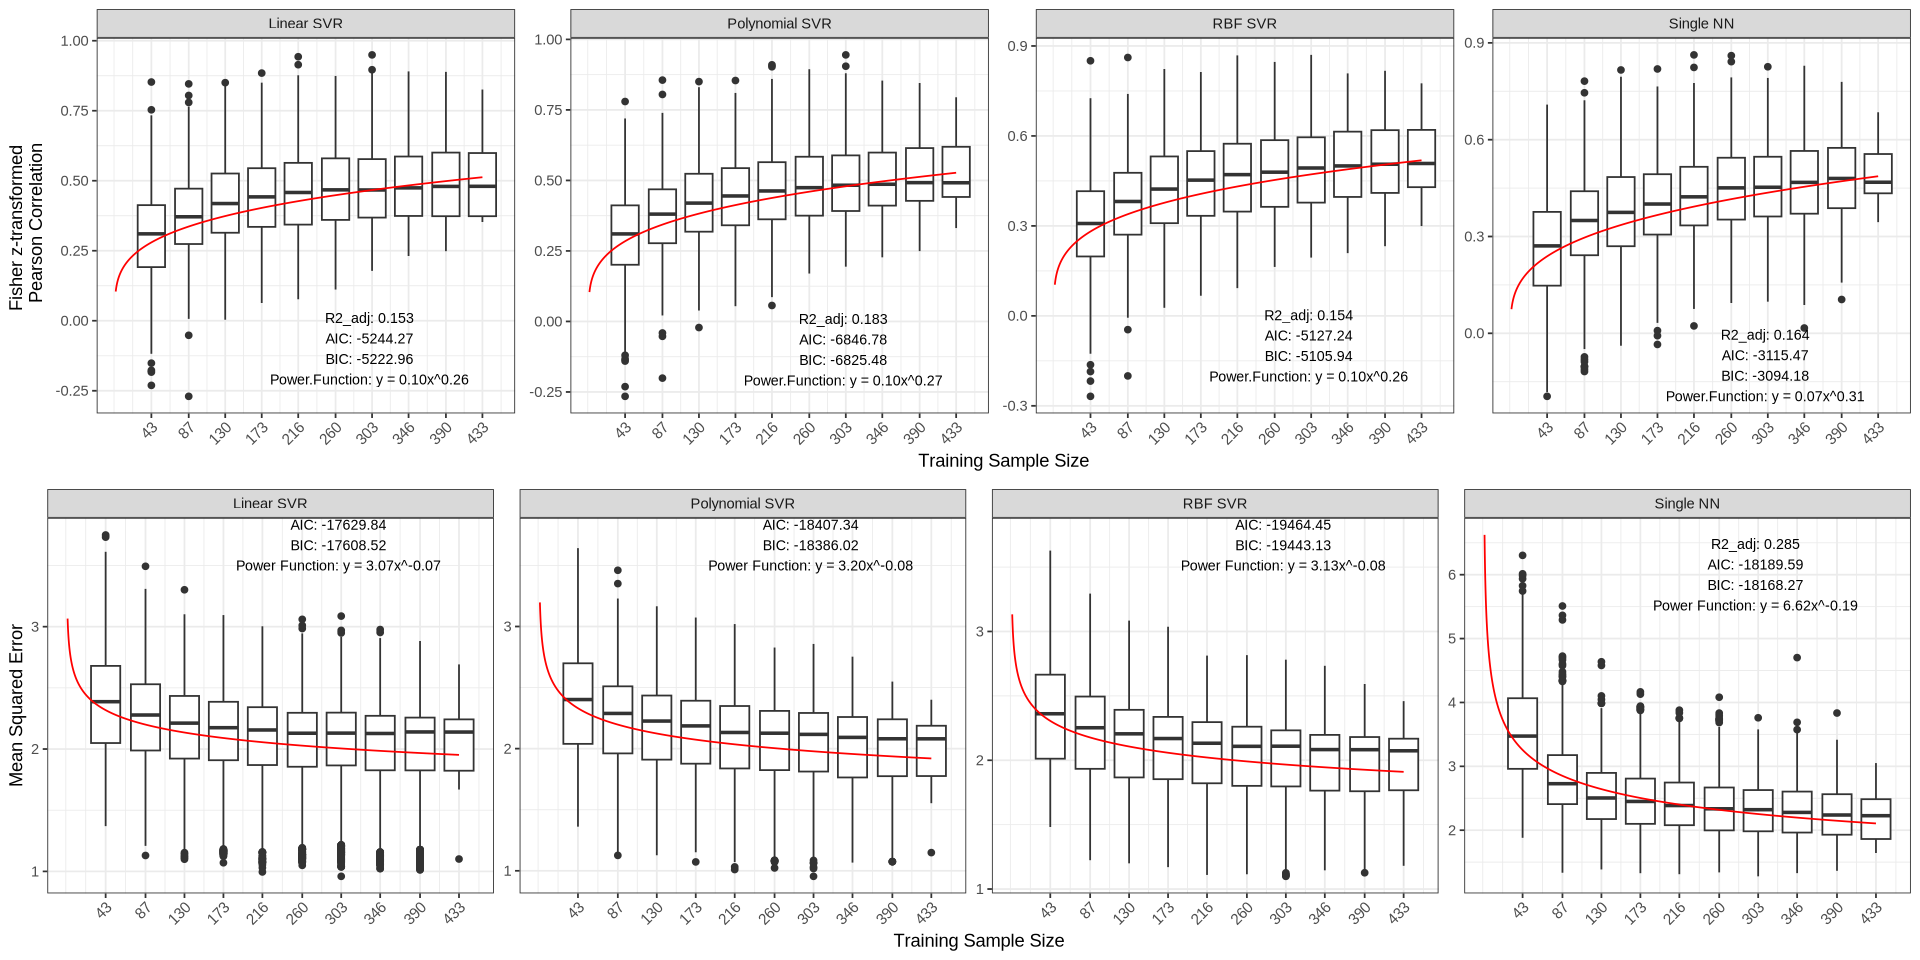

In [33]:
h = 8
w = 16

options(repr.plot.width = w, repr.plot.height = h)

model_map <- c("linearSVR" = "Linear SVR", 
               "rbfSVR" = "RBF SVR", 
               "polySVR" = "Polynomial SVR")

annotation_df<-final_df[(final_df$Model == 'power') & (final_df$Performance.Metric == 'Pearson'), ]
annotation_df =  annotation_df %>% select(-Model) %>%
mutate(model = factor(Input, levels = names(title_map), labels = title_map))

annotation_df['Power.Function']<-power_plots_label[power_plots_label$performance.metric == 'test_corr',] %>%
distinct(model, label) %>%
arrange(match(model, annotation_df$model)) %>%
select(label)

annotation_df<-annotation_df%>%
mutate(label = sprintf("R2_adj: %.3f\nAIC: %.2f\nBIC: %.2f\nPower.Function: %s", R2_adj, AIC, BIC,Power.Function)) %>%
select(model, label)
annotation_df[['x']] = 300
annotation_df[['y']] = -0.1

g1 <- ggplot() +
  geom_boxplot(data = viz.df[viz.df$performance.metric == 'test_corr',], 
               aes(x = as.numeric(train_sample_size), y = value, group = train_sample_size))+
  geom_line(data = power_plots[power_plots$performance.metric == 'test_corr',], 
            aes(x = as.numeric(train_sample_size), y = value), color = 'red') + 
# facet_grid(~model, scales = "free_y") + 
 facet_wrap(~model, ncol = 4, scales = "free_y")+
geom_text(data = annotation_df, aes(x = x, y = y, label = label), inherit.aes = T, size = 3) +
labs(x = "Training Sample Size", y = "Fisher z-transformed \n Pearson Correlation") +
theme_bw() + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
scale_x_continuous(breaks = sapply(seq(0, max(res$train_sample_size), length=11)[2:11], function(x) round(x)))

# MSE
annotation_df<-final_df[(final_df$Model == 'power') & (final_df$Performance.Metric == 'MSE'), ]
annotation_df =  annotation_df %>% select(-Model) %>%
mutate(model = factor(Input, levels = names(title_map), labels = title_map))

annotation_df['Power.Function']<-power_plots_label[power_plots_label$performance.metric == 'test_mse',] %>%
distinct(model, label) %>%
arrange(match(model, annotation_df$model)) %>%
select(label)

annotation_df<-annotation_df%>%
mutate(label = sprintf("R2_adj: %.3f\nAIC: %.2f\nBIC: %.2f\nPower Function: %s", R2_adj, AIC, BIC,Power.Function)) %>%
select(model, label)
annotation_df[['x']] = 300
annotation_df[['y']] = 3.75
annotation_df[1, c('x', 'y')] = c(300, 6)

g2 <- ggplot() +
  geom_boxplot(data = viz.df[viz.df$performance.metric == 'test_mse',], 
               aes(x = as.numeric(train_sample_size), y = value, group = train_sample_size))+
  geom_line(data = power_plots[power_plots$performance.metric == 'test_mse',], 
            aes(x = as.numeric(train_sample_size), y = value), color = 'red') + 
# facet_grid(~model, scales = "free_y") + 
facet_wrap(~model, ncol = 4, scales = "free_y")+
geom_text(data = annotation_df, aes(x = x, y = y, label = label), inherit.aes = T, size = 3) +
labs(x = "Training Sample Size", y = "Mean Squared Error") +
theme_bw() + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
scale_x_continuous(breaks = sapply(seq(0, max(res$train_sample_size), length=11)[2:11], function(x) round(x)))

g<-plot_grid(g1, g2, ncol = 1)
                                   
ggsave(filename = file.path(data_path, "figures", "power_analysis_barplots.png"), 
       plot = g, dpi = 300, width = w, height = h)
                           
g


## Multivariable modeling to understand which model type works the best

In [34]:
curr_df <- df %>%
mutate(
    log10_test_corr = log10(test_corr),
    log10_train_sample_size = log10(train_sample_size),
    log10_test_mse = log10(test_mse),
    
    # This transformation enables a bounded variable (r is bounded by [-1,1]) to be treated as a continuous variable
    fisherZ_test_corr = 0.5 * log((1 + test_corr) / (1 - test_corr)),
    log10_fisherZ_test_corr = log10(fisherZ_test_corr)
)

multi_R2_model <- lm(
    log10_fisherZ_test_corr ~ log10_train_sample_size + model,
    data = curr_df
)

summary(multi_R2_model)

calc_metrics(multi_R2_model, curr_df, df$test_corr, log_transformed = F)

# forest_model(multi_R2_model)

# ggsave('Output/MultivariableR2Model.pdf', useDingbats = F, units = 'in', h = 6, w = 8)

Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”



Call:
lm(formula = log10_fisherZ_test_corr ~ log10_train_sample_size + 
    model, data = curr_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.8077 -0.0921  0.0265  0.1189  0.4923 

Coefficients:
                         Estimate Std. Error  t value Pr(>|t|)    
(Intercept)             -1.011898   0.007707 -131.293  < 2e-16 ***
log10_train_sample_size  0.275647   0.003306   83.374  < 2e-16 ***
modelsvr_rbf             0.004173   0.002736    1.525 0.127173    
modelsvr_poly            0.010363   0.002736    3.788 0.000152 ***
modelANN                -0.040097   0.002738  -14.643  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1833 on 35844 degrees of freedom
  (191 observations deleted due to missingness)
Multiple R-squared:  0.1704,	Adjusted R-squared:  0.1703 
F-statistic:  1840 on 4 and 35844 DF,  p-value: < 2.2e-16


MSE      RMSE 
0.6506538 0.8066311

In [35]:
# curr_df <- df %>%
# mutate(
#     log10_test_corr = log10(test_corr),
#     log10_train_sample_size = log10(train_sample_size),
#     log10_test_mse = log10(test_mse),
    
#     # This transformation enables a bounded variable (r is bounded by [-1,1]) to be treated as a continuous variable
#     fisherZ_test_corr = 0.5 * log((1 + test_corr) / (1 - test_corr)),
#     log10_fisherZ_test_corr = log10(fisherZ_test_corr)
# )

# multi_R2_linear_model <- lm(
#     fisherZ_test_corr ~ train_sample_size + model,
#     data = curr_df
# )

# summary(multi_R2_linear_model)

# calc_metrics(multi_R2_linear_model, curr_df, df$test_corr, log_transformed = F)

# forest_model(multi_R2_linear_model)

# # ggsave('Output/MultivariableR2Model.pdf', useDingbats = F, units = 'in', h = 6, w = 8)

In [36]:
curr_df <- df %>%
mutate(
    log10_test_corr = log10(test_corr),
    log10_train_sample_size = log10(train_sample_size),
    log10_test_mse = log10(test_mse)
)
multi_mse_model <- lm(
    log10_test_mse ~ log10_train_sample_size + model,
    data = curr_df
)

summary(multi_mse_model)

calc_metrics(multi_mse_model, curr_df, df$test_corr, log_transformed = T)

# forest_model(multi_mse_model)

# ggsave('Output/MultivariableMSEModel.pdf', useDingbats = F, units = 'in', h = 6, w = 8)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_mse ~ log10_train_sample_size + model, 
    data = curr_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.31248 -0.04999  0.01737  0.06078  0.33740 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)              0.560510   0.003672 152.656  < 2e-16 ***
log10_train_sample_size -0.107156   0.001576 -68.009  < 2e-16 ***
modelsvr_rbf            -0.006757   0.001315  -5.139 2.77e-07 ***
modelsvr_poly           -0.003573   0.001315  -2.718  0.00658 ** 
modelANN                 0.076668   0.001315  58.310  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.08825 on 36035 degrees of freedom
Multiple R-squared:  0.221,	Adjusted R-squared:  0.2209 
F-statistic:  2555 on 4 and 36035 DF,  p-value: < 2.2e-16


MSE     RMSE 
1.027741 1.013776

Visualize:

In [37]:
viz.df<-summary(multi_R2_model)$coefficients
rownames(viz.df)<-c('Intercept', 'log10(Train Sample Size)', 'Polynomial SVR', 'RBF SVR', 'Single NN')
viz.df<-as.data.frame(viz.df) %>% tibble::rownames_to_column("term")

# g1<-ggplot(viz.df, aes(x = term, y = Estimate)) +
#   geom_point() + 
#   geom_errorbar(aes(ymin = Estimate - `Std. Error`, ymax = Estimate + `Std. Error`), width = 0.2) +
#   theme_bw() +
#   labs(x = "Predictor", y = "Estimate", title = 'Fisher z-transformed Pearson Correlation')+
# theme(plot.title = element_text(hjust = 0.5))

In [104]:
viz.df<-summary(multi_R2_model)$coefficients
rownames(viz.df)<-c('Intercept', 'log10(Train Sample Size)', 'Polynomial SVR', 'RBF SVR', 'Single NN')
viz.df<-as.data.frame(viz.df) %>% tibble::rownames_to_column("term")

g1<-ggplot(viz.df, aes(x = term, y = Estimate)) +
  geom_point() + 
  geom_errorbar(aes(ymin = Estimate - `Std. Error`, ymax = Estimate + `Std. Error`), width = 0.2) +
  theme_bw() +
  labs(x = "Predictor", y = "Estimate", title = 'Fisher z-transformed Pearson Correlation')+
theme_set(theme_bw(base_size = 16))+
theme(plot.title = element_text(hjust = 0.5), 
     axis.text.x = element_text(angle = 45, hjust = 1))


# plot the predictions
inverse_fisher_z <- function(z) {
  return((exp(2 * z) - 1) / (exp(2 * z) + 1))
}


predicted.data <- expand.grid(
  train_sample_size = seq(1, 1e4, length.out = 1e4), 
  model = c("svr_linear", "svr_poly", "svr_rbf", 'ANN')     
) %>%
  mutate(log10_train_sample_size = log10(train_sample_size))

predicted.data$log10_fisherZ_test_corr <- predict(multi_R2_model, newdata = predicted.data)
predicted.data$fisherZ_test_corr<-10^predicted.data$log10_fisherZ_test_corr
predicted.data$test_corr<-inverse_fisher_z(predicted.data$fisherZ_test_corr)

title_map <- c("svr_linear" = "Linear SVR", 
               "svr_rbf" = "RBF SVR", 
               "svr_poly" = "Polynomial SVR", 
              'ANN' = 'Single NN')

predicted.data <- predicted.data %>%
  mutate(model_title = factor(model, levels = names(title_map), labels = title_map)) %>%
select(-model) %>% rename(model = model_title)

predicted.data.corr<-predicted.data


pf<-summary(multi_R2_model)$coefficients
a=10^pf['(Intercept)', 'Estimate']
b = pf['log10_train_sample_size', 'Estimate']

m="model"
i = 'i'
m_i <- sprintf("%s[%s]", m, i)
equation = parse(text = sprintf("z == %.2f ~ N^%.2f ~ '×' ~ 10^%s", a, b, m_i))

m <- "model"
i <- "polynomial_svr"
m_i_value <- pf['modelsvr_poly','Estimate'] 
poly_m_i <- parse(text = sprintf("%s[%s] == %.2f", m, i, m_i_value))

m <- "model"
i <- "rbf_svr"
m_i_value <- pf['modelsvr_rbf','Estimate'] 
rbf_m_i <- parse(text = sprintf("%s[%s] == %.2f", m, i, m_i_value))

m <- "model"
i <- "ANN"
m_i_value <- pf['modelANN','Estimate'] 
ann_m_i <- parse(text = sprintf("%s[%s] == %.2f", m, i, m_i_value))

viz.df.main<-predicted.data
names(viz.df.main)[names(viz.df.main) == "model"] <- "Model"
g2_main<-ggplot(viz.df.main, aes(x = train_sample_size, y = test_corr, 
                               color = Model)) +
  geom_line(linewidth = 0.75) + 
  theme_bw() +
  labs(x = "Train Sample Size", y = "Pearson Correlation", title = 'Predicted Performance by Model Type')+
theme(plot.title = element_text(hjust = 0.5)) + 
theme(
  plot.title = element_text(size = rel(1.5)),
  axis.title = element_text(size = rel(1.5)),
  axis.text = element_text(size = rel(1.5)),
  legend.title = element_text(size = rel(1.5)),
  legend.text = element_text(size = rel(1.5))
)

g2<-g2_main+
geom_text(
  data = data.frame(x = 7500, y = 0.4, label = deparse(equation[[1]])),
  aes(x = x, y = y, label = label),
  parse = TRUE,
  inherit.aes = FALSE,
  size = 7.5,
  fontface = "bold"
)+
geom_text(
  data = data.frame(x = 7500, y = 0.3, label = deparse(poly_m_i[[1]])),
  aes(x = x, y = y, label = label),
  parse = TRUE,
  inherit.aes = FALSE,
  size = 7.5,
  fontface = "bold"
)+
geom_text(
  data = data.frame(x = 7500, y = 0.2, label = deparse(rbf_m_i[[1]])),
  aes(x = x, y = y, label = label),
  parse = TRUE,
  inherit.aes = FALSE,
  size = 7.5,
  fontface = "bold"
)+
geom_text(
  data = data.frame(x = 7500, y = 0.1, label = deparse(ann_m_i[[1]])),
  aes(x = x, y = y, label = label),
  parse = TRUE,
  inherit.aes = FALSE,
  size = 7.5,
  fontface = "bold"
)




# g<-plot_grid(g1, g2, ncol = 2)
# g                 
# ggsave(filename = file.path(data_path, "figures", "corr_power_analysis_model_fit.png"), 
#        plot = g, dpi = 300, width = w, height = h)


In [107]:
h = 4
w = 12

options(repr.plot.width = w, repr.plot.height = h)

viz.df<-summary(multi_mse_model)$coefficients
rownames(viz.df)<-c('Intercept', 'log10(Train Sample Size)', 'Polynomial SVR', 'RBF SVR', 'Single NN')
viz.df<-as.data.frame(viz.df) %>% tibble::rownames_to_column("term")

g1B<-ggplot(viz.df, aes(x = term, y = Estimate)) +
  geom_point() + 
  geom_errorbar(aes(ymin = Estimate - `Std. Error`, ymax = Estimate + `Std. Error`), width = 0.2) +
  theme_bw() +
  labs(x = "Predictor", y = "Estimate", title = 'Mean Squared Error')+
theme_set(theme_bw(base_size = 16))+
theme(plot.title = element_text(hjust = 0.5), 
     axis.text.x = element_text(angle = 45, hjust = 1))



predicted.data <- expand.grid(
  train_sample_size = seq(1, 1e4, length.out = 1e4), 
  model = c("svr_linear", "svr_poly", "svr_rbf", 'ANN')     
) %>%
  mutate(log10_train_sample_size = log10(train_sample_size))

predicted.data$log10_mse <- predict(multi_mse_model, newdata = predicted.data)
predicted.data$test_mse<-10^predicted.data$log10_mse

title_map <- c("svr_linear" = "Linear SVR", 
               "svr_rbf" = "RBF SVR", 
               "svr_poly" = "Polynomial SVR", 
              'ANN' = 'Single NN')

predicted.data <- predicted.data %>%
  mutate(model_title = factor(model, levels = names(title_map), labels = title_map)) %>%
select(-model) %>% rename(model = model_title)


pf<-summary(multi_mse_model)$coefficients
a=10^pf['(Intercept)', 'Estimate']
b = pf['log10_train_sample_size', 'Estimate']

m="model"
i = 'i'
m_i <- sprintf("%s[%s]", m, i)
equation = parse(text = sprintf("MSE == %.2f ~ N^%.2f ~ '×' ~ 10^%s", a, b, m_i))

m <- "model"
i <- "polynomial_svr"
m_i_value <- pf['modelsvr_poly','Estimate'] 
poly_m_i <- parse(text = sprintf("%s[%s] == %.3f", m, i, m_i_value))

m <- "model"
i <- "rbf_svr"
m_i_value <- pf['modelsvr_rbf','Estimate'] 
rbf_m_i <- parse(text = sprintf("%s[%s] == %.3f", m, i, m_i_value))

m <- "model"
i <- "ANN"
m_i_value <- pf['modelANN','Estimate'] 
ann_m_i <- parse(text = sprintf("%s[%s] == %.2f", m, i, m_i_value))

g2B<-ggplot(predicted.data, aes(x = train_sample_size, y = test_mse, 
                               color = model)) +
  geom_line() + 
  theme_bw() +
  labs(x = "Train Sample Size", y = "Mean Squared Error", title = 'Predicted Performance by Model Type')+
theme(plot.title = element_text(hjust = 0.5))+
theme(
  plot.title = element_text(size = rel(1.5)),
  axis.title = element_text(size = rel(1.5)),
  axis.text = element_text(size = rel(1.5)),
  legend.title = element_text(size = rel(1.5)),
  legend.text = element_text(size = rel(1.5))
)+
geom_text(
  data = data.frame(x = 7500, y = 3.00, label = deparse(equation[[1]])),
  aes(x = x, y = y, label = label),
  parse = TRUE,
  inherit.aes = FALSE,
  size = 7.5,
  fontface = "bold"
)+
geom_text(
  data = data.frame(x = 7500, y = 2.75, label = deparse(poly_m_i[[1]])),
  aes(x = x, y = y, label = label),
  parse = TRUE,
  inherit.aes = FALSE,
  size = 7.5,
  fontface = "bold"
)+
geom_text(
  data = data.frame(x = 7500, y = 2.5, label = deparse(rbf_m_i[[1]])),
  aes(x = x, y = y, label = label),
  parse = TRUE,
  inherit.aes = FALSE,
  size = 7.5,
  fontface = "bold"
)+
geom_text(
  data = data.frame(x = 7500, y = 2.25, label = deparse(ann_m_i[[1]])),
  aes(x = x, y = y, label = label),
  parse = TRUE,
  inherit.aes = FALSE,
  size = 7.5,
  fontface = "bold"
)


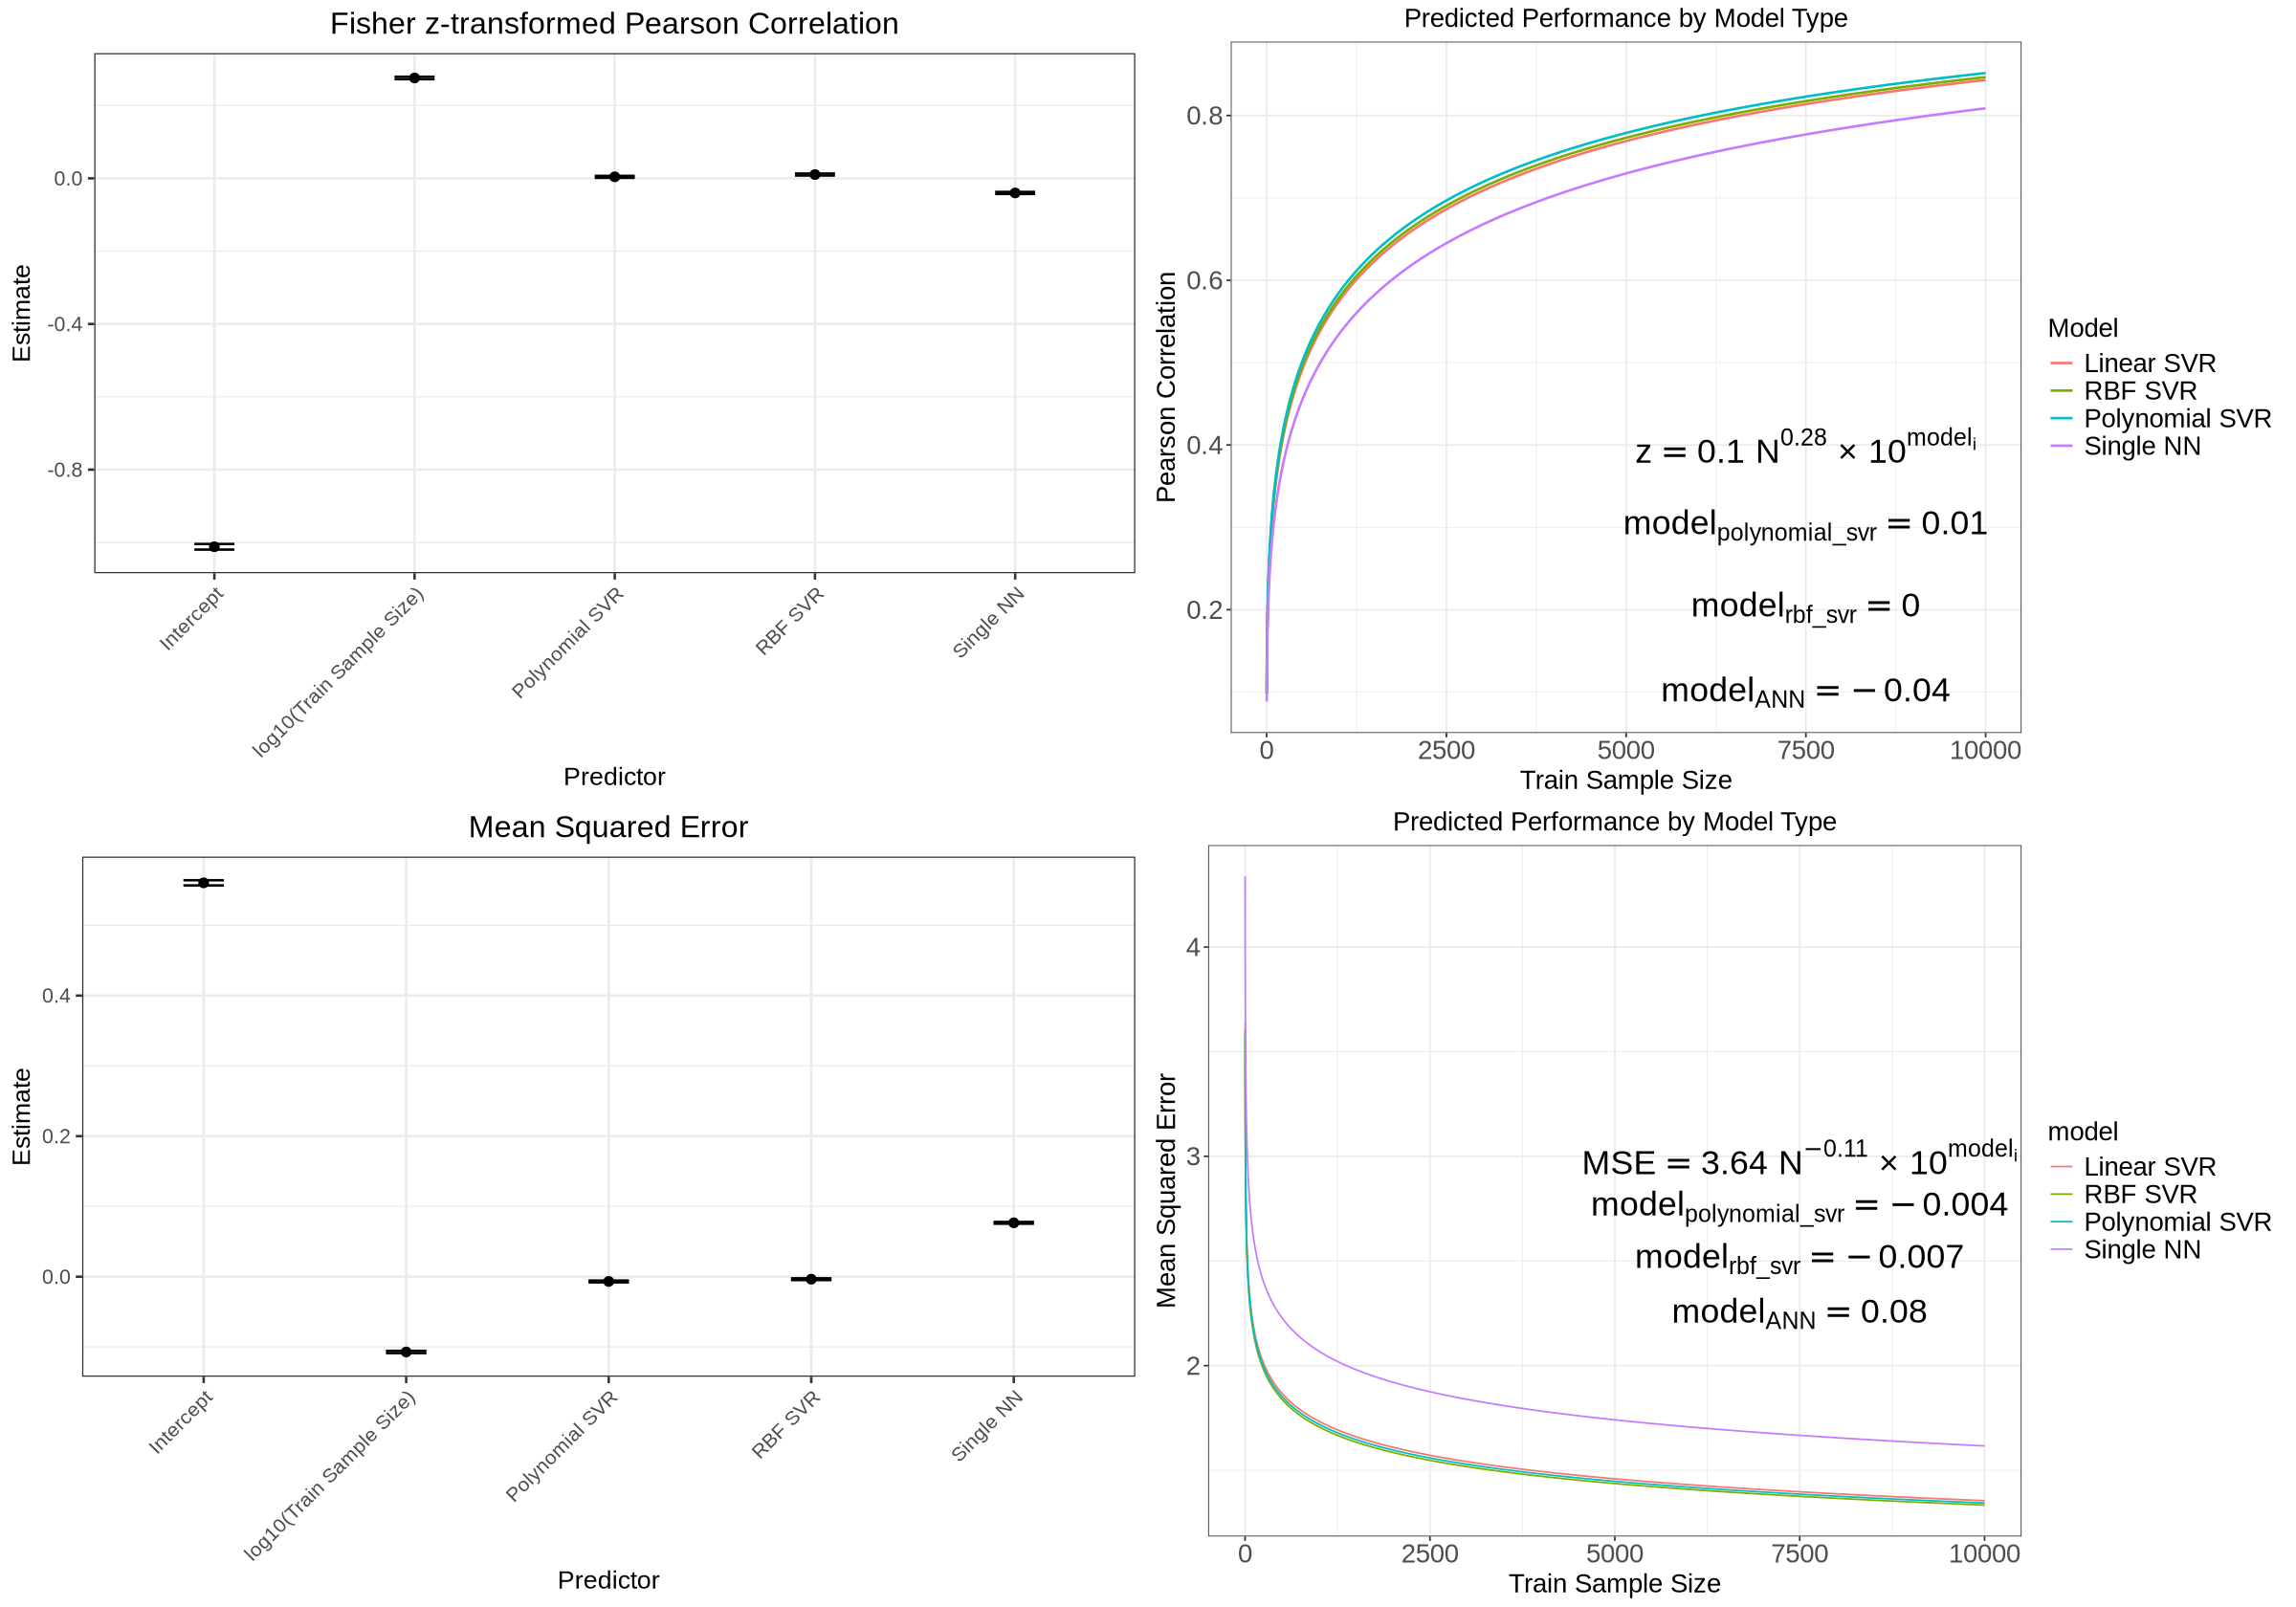

In [108]:
h = 14
w = 20

options(repr.plot.width = w, repr.plot.height = h)
g<-plot_grid(g1, g2, g1B, g2B, ncol = 2)

g                 
ggsave(filename = file.path(data_path, "figures", "power_analysis_model_fits_all.png"), 
       plot = g, dpi = 300, width = w, height = h)

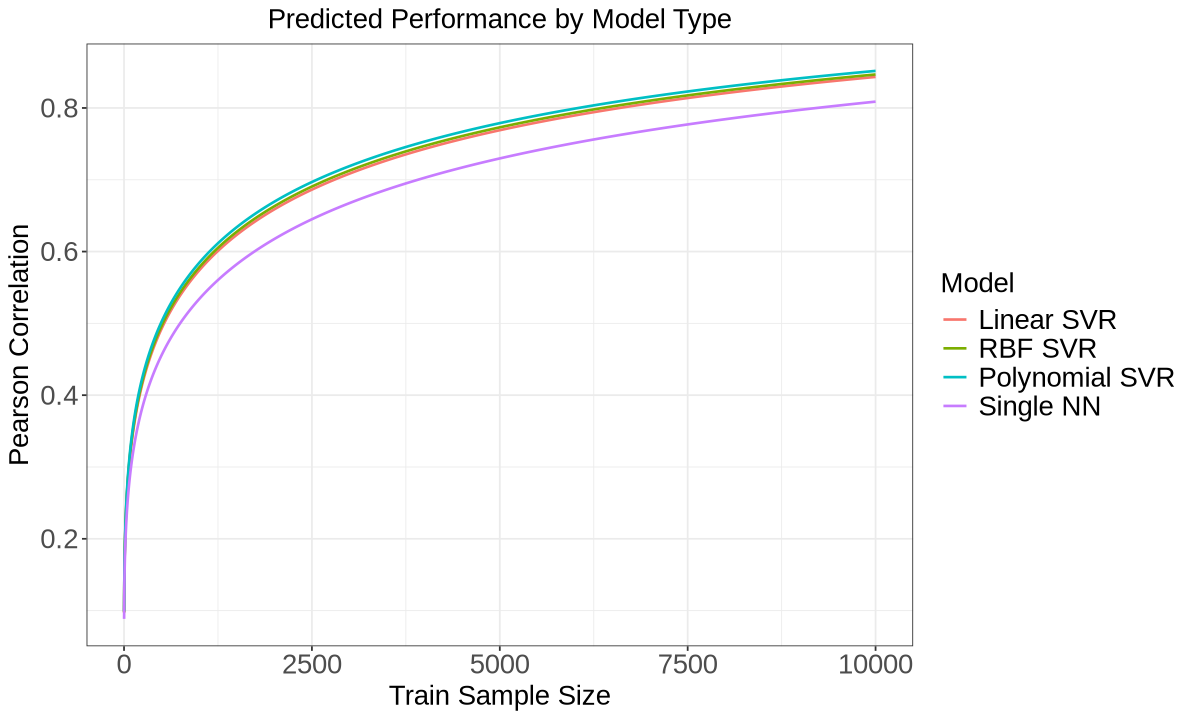

In [109]:
h = 6
w = 10

options(repr.plot.width = w, repr.plot.height = h)
g2_main

ggsave(filename = file.path(data_path, "figures", "power_analysis_predictino_pearson.png"), 
       plot = g2_main, dpi = 300, width = w, height = h)


In [110]:
pf = summary(multi_R2_model)$coefficients
pf

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-1.011898052,0.007707154,-131.293351,0.000000e+00
log10_train_sample_size,0.275646607,0.003306148,83.373947,0.000000e+00
modelsvr_rbf,0.004173373,0.002735958,1.525379,1.271735e-01
modelsvr_poly,0.010363092,0.002735882,3.787844,1.522084e-04
modelANN,-0.040097393,0.002738340,-14.642958,2.062606e-48


In [111]:
summary(multi_mse_model)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.560510294,0.003671728,152.655718,0.000000e+00
log10_train_sample_size,-0.107155757,0.001575601,-68.009444,0.000000e+00
modelsvr_rbf,-0.006757443,0.001314819,-5.139447,2.769842e-07
modelsvr_poly,-0.003573381,0.001314819,-2.717774,6.575413e-03
modelANN,0.076667693,0.001314819,58.310450,0.000000e+00


Max p-value:

In [112]:
max(rbind(pf, summary(multi_mse_model)$coefficients)[, 4])

[1] 0.1271735

Let's see how these translate to the original power function. We expect that, at a given sample size, the nonlinear model will perform 10^model_estimate better than the linear model for fisherZ_test_corr. 

For the rbf, this should be:

In [113]:
10^pf['modelsvr_rbf', 'Estimate']

[1] 1.009656

For svr, this should be: 

In [114]:
10^pf['modelsvr_poly', 'Estimate']

[1] 1.024149

For NNs:

In [115]:
10^pf['modelANN', 'Estimate']

[1] 0.9118063

In [116]:
fz_pd_c = dcast(predicted.data.corr, train_sample_size ~ model, value.var = 'fisherZ_test_corr')
head(fz_pd_c)

,train_sample_size,Linear SVR,RBF SVR,Polynomial SVR,Single NN
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.09729756,0.09823705,0.09964719,0.08871653
2,2,0.11778225,0.11891954,0.12062656,0.10739460
3,3,0.13171002,0.13298179,0.13489066,0.12009403
4,4,0.14257971,0.14395645,0.14602285,0.13000509
5,5,0.15162495,0.15308902,0.15528652,0.13825259
6,6,0.15943979,0.16097931,0.16329008,0.14537821


In [117]:
head(fz_pd_c[['RBF SVR']]/fz_pd_c[['Linear SVR']])

[1] 1.009656 1.009656 1.009656 1.009656 1.009656 1.009656

In [118]:
head(fz_pd_c[['Polynomial SVR']]/fz_pd_c[['Linear SVR']])

[1] 1.024149 1.024149 1.024149 1.024149 1.024149 1.024149

In [119]:
head(fz_pd_c[['Single NN']]/fz_pd_c[['Linear SVR']])

[1] 0.9118063 0.9118063 0.9118063 0.9118063 0.9118063 0.9118063

In terms of the actual Pearson correlation, this means:

In [120]:
r_pd_c = dcast(predicted.data.corr, train_sample_size ~ model, value.var = 'test_corr')
r_pd_c$RBF.norm<-r_pd_c[['RBF SVR']]/r_pd_c[['Linear SVR']]
r_pd_c$Polynomial.norm<-r_pd_c[['Polynomial SVR']]/r_pd_c[['Linear SVR']]
r_pd_c$ANN.norm<-r_pd_c[['Single NN']]/r_pd_c[['Linear SVR']]

In [121]:
mean(r_pd_c$RBF.norm)

[1] 1.005507

In [122]:
mean(r_pd_c$Polynomial.norm)

[1] 1.013637

In [123]:
mean(r_pd_c$ANN.norm)

[1] 0.9462544

In [124]:
predicted.data.corr[predicted.data.corr$train_sample_size == 10000, ]

,train_sample_size,log10_train_sample_size,log10_fisherZ_test_corr,fisherZ_test_corr,test_corr,model
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
10000,10000,4,0.09068838,1.232220,0.8432222,Linear SVR
20000,10000,4,0.10105147,1.261977,0.8516083,Polynomial SVR
30000,10000,4,0.09486175,1.244119,0.8466261,RBF SVR
40000,10000,4,0.05059098,1.123546,0.8087989,Single NN


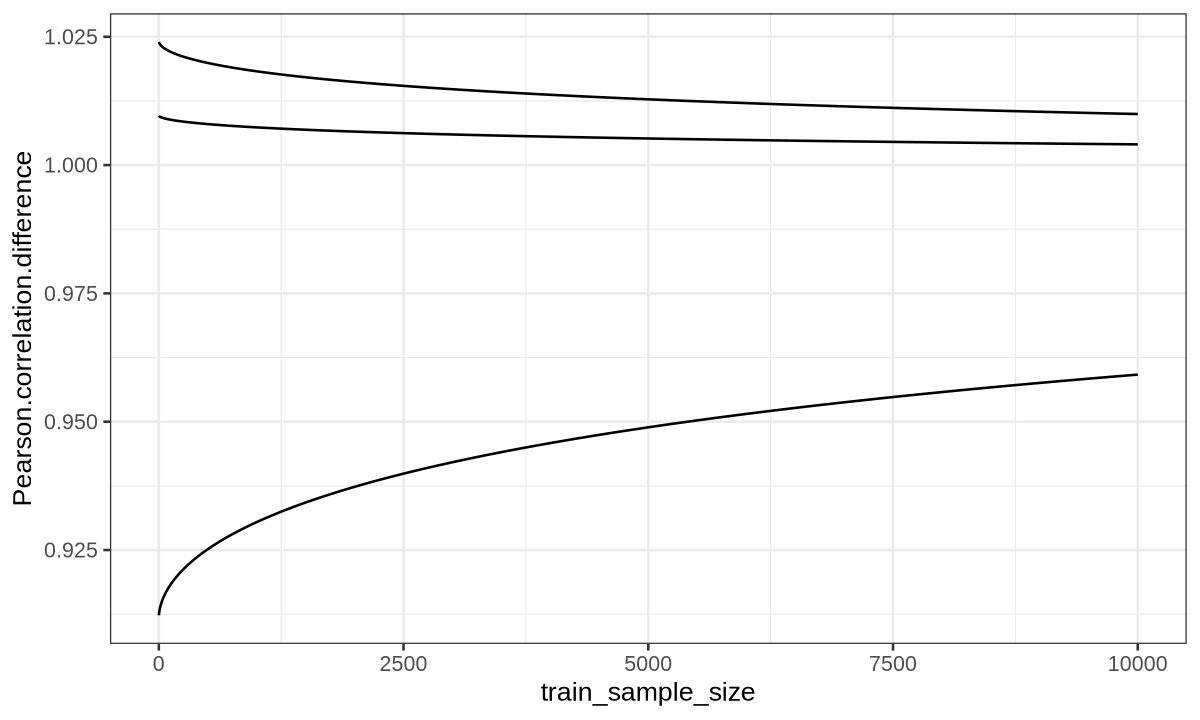

In [125]:
viz.df<-melt(r_pd_c %>% select(train_sample_size, RBF.norm, Polynomial.norm, ANN.norm), 
             id.vars = c('train_sample_size'), variable.name='model.type', 
            value.name='Pearson.correlation.difference')

ggplot(data = viz.df, 
       aes(x = train_sample_size, y = Pearson.correlation.difference, group = model.type)) + 
  geom_line()

In [126]:
figs = c(file.path(data_path, "figures", "power_analysis_barplots.png"),
file.path(data_path, "figures", "power_analysis_model_fits_all.png"),
file.path(data_path, "figures", "power_analysis_predictino_pearson.png"))

for (fig in figs){
    cmd = paste0('scp hmbaghda@orcd-login001.mit.edu:', fig, ' Downloads/mp_materials/mp_figures/.')
    print(cmd)
}

[1] "scp hmbaghda@orcd-login001.mit.edu:/home/hmbaghda/orcd/pool/metastatic_potential//figures/power_analysis_barplots.png Downloads/mp_materials/mp_figures/."
[1] "scp hmbaghda@orcd-login001.mit.edu:/home/hmbaghda/orcd/pool/metastatic_potential//figures/power_analysis_model_fits_all.png Downloads/mp_materials/mp_figures/."
[1] "scp hmbaghda@orcd-login001.mit.edu:/home/hmbaghda/orcd/pool/metastatic_potential//figures/power_analysis_predictino_pearson.png Downloads/mp_materials/mp_figures/."
